In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import HBPASM.data.data as data
import os
import torch.backends.cudnn as cudnn
from PIL import Image
import HBPASM.model.HBPASM_model as HBPASM_model
from torchvision import datasets, ops
from HBPASM.utils.utils import progress_bar
import torchmetrics
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torchsummary import summary
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import LambdaLR
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Lambda
from focal_loss import FocalLoss
import torchvision
from albumentations.core.transforms_interface import DualTransform
import albumentations as A
from albumentations.pytorch import ToTensorV2
import differaugment as augment
from Ranger21.ranger21.ranger21 import Ranger21
import custom_utils as custom_utils
from WeightedKappaLoss import WeightedKappaLoss
import torchvision.transforms.functional as F
from sklearn.model_selection import KFold
from ordinalencodedmodel import ModelVer1,ModelVer1FocalLosswithSGD,ModelVer1FocalLossonly
import encodetestoptimizermodel as optimizermodel
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
import copy

    

class CustomImageFolder(DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            try:
                sample = self.transform(sample)
            except Exception:
                sample = self.transform(image=np.array(sample))["image"]
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)

# normal aug

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 8100 of 11250
warm down will decay until 3e-05 lr
----------------------------------------Epoch: 1----------------------------------------
params size saved
total param groups = 1
total params in groups = 558
 [=======================================>]  Step: 563ms | Tot: 43s937ms | loss: 2.0007 | tra 75/75 

Train set: Average loss: 2.0180, Cohen's Kappa: 0.0069, QWK Score: -0.0099, Accuracy: (41.92%), F1-Score: 0.1697, Specif

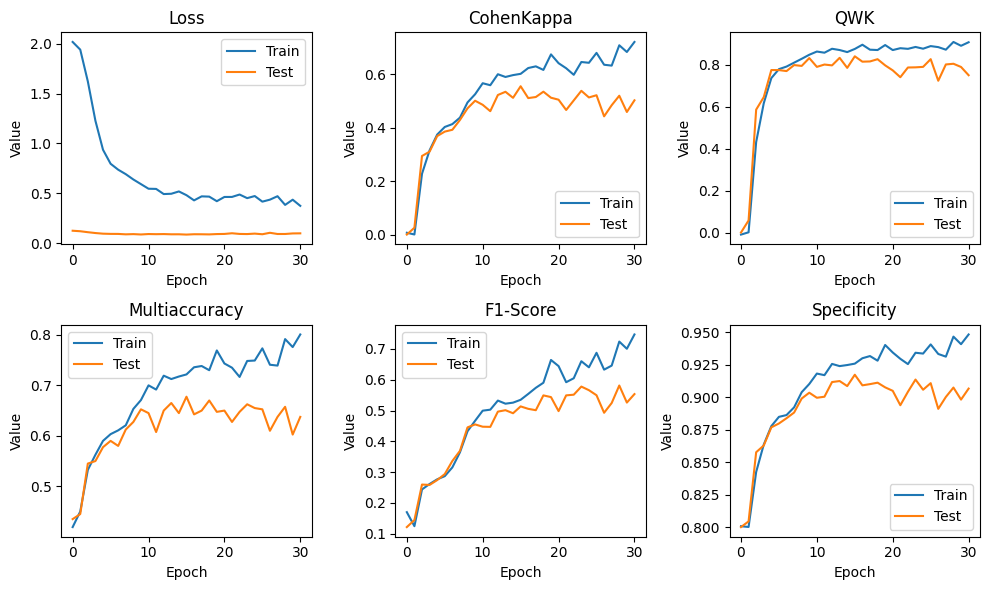

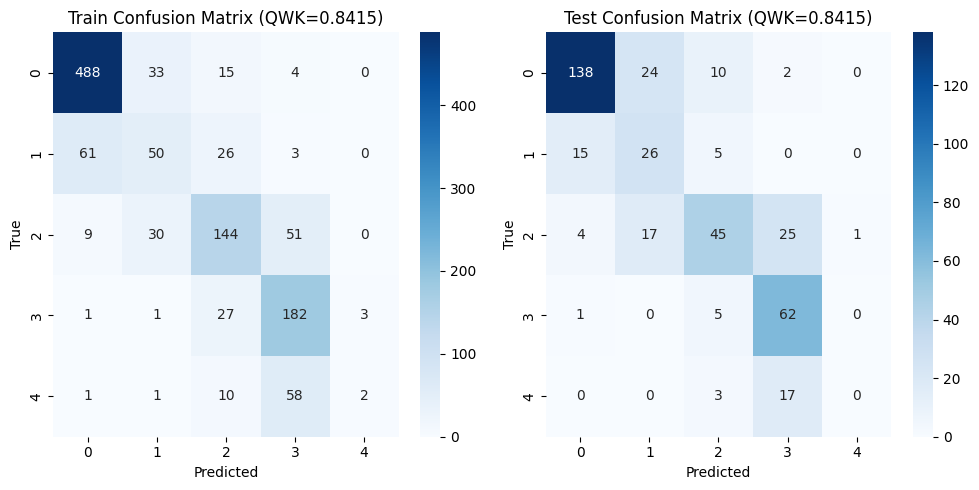

In [2]:
IMG_SIZE=300
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridtrain')
trainset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor(),
                                                ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)

image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridvalid')
testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True
model=optimizermodel.ModelRanger21(filename='DSODHBPASM_ranger21_300circlecropnormalaug',lr=0.001,num_batches_per_epoch=len(trainloader))

df=model.traintest(150,trainloader,testloader)
custom_utils.plot_metrics(df)
custom_utils.plot_confusion_matrix_with_max_qwk(df)
torch.cuda.empty_cache()

# randaug

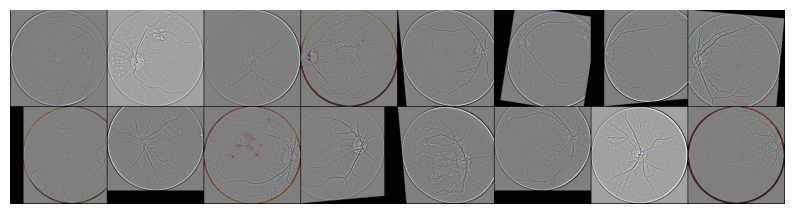

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 8100 of 11250
warm down will decay until 3e-05 lr
----------------------------------------Epoch: 1----------------------------------------
params size saved
total param groups = 1
total params in groups = 558
 [=======================================>]  Step: 2s481ms | Tot: 3m24s | loss: 2.0092 | tra 75/75 5 5 

Train set: Average loss: 2.0256, Cohen's Kappa: 0.0002, QWK Score: 0.0204, Accuracy: (30.08%), F1-Score: 0.1830, Spec

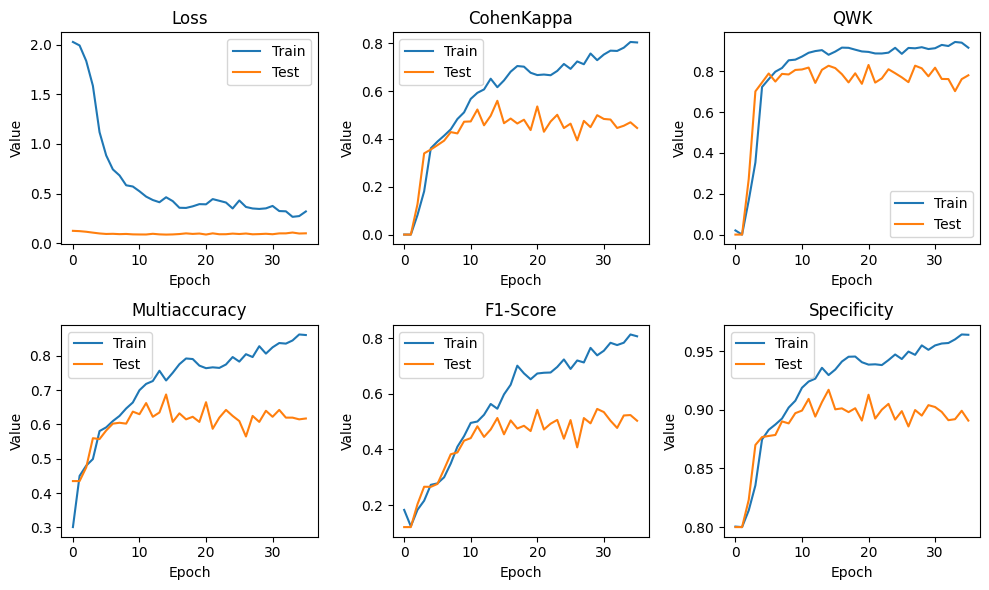

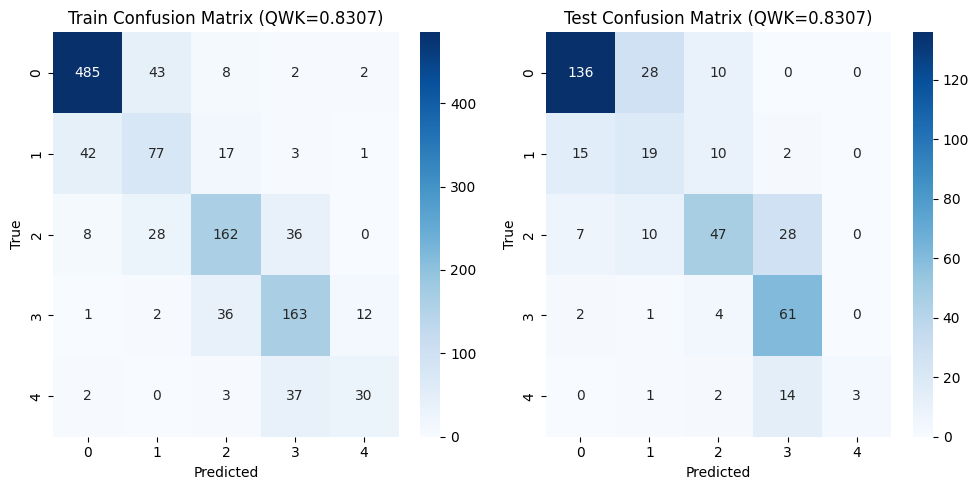

In [2]:
IMG_SIZE=300
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridtrain')
trainset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                augment.RandAugment(),
                                                transforms.ToTensor(),
                                                ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)

image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridvalid')
testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
# save wrong file should be DSODHBPASM_ranger21_300circlecroprandaug edited for the output file
model=optimizermodel.ModelRanger21(filename='DSODHBPASM_ranger21_300circlecroprandaug',lr=0.001,num_batches_per_epoch=len(trainloader))

df=model.traintest(150,trainloader,testloader)
custom_utils.plot_metrics(df)
custom_utils.plot_confusion_matrix_with_max_qwk(df)
torch.cuda.empty_cache()

# trivial aug

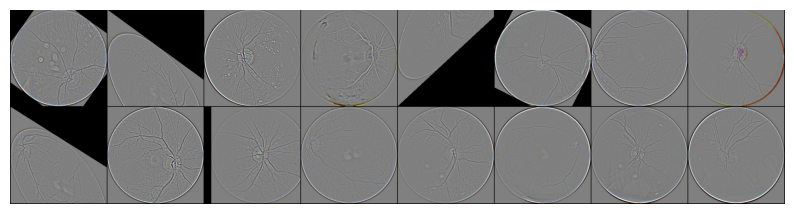

Model : HBPASM with DSOD
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 8100 of 11250
warm down will decay until 3e-05 lr
----------------------------------------Epoch: 1----------------------------------------
params size saved
total param groups = 1
total params in groups = 558
 [=======================================>]  Step: 534ms | Tot: 39s604ms | loss: 2.0153 | tra 75/75 

Train set: Average loss: 2.0236, Cohen's Kappa: -0.0089, QWK Score: 0.0238, Accuracy: (35.25%),

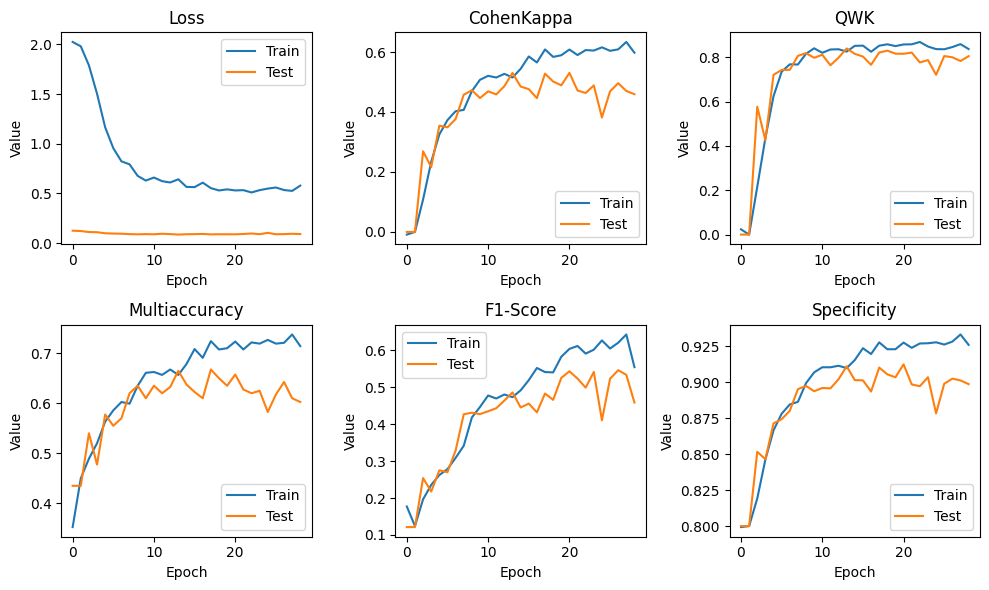

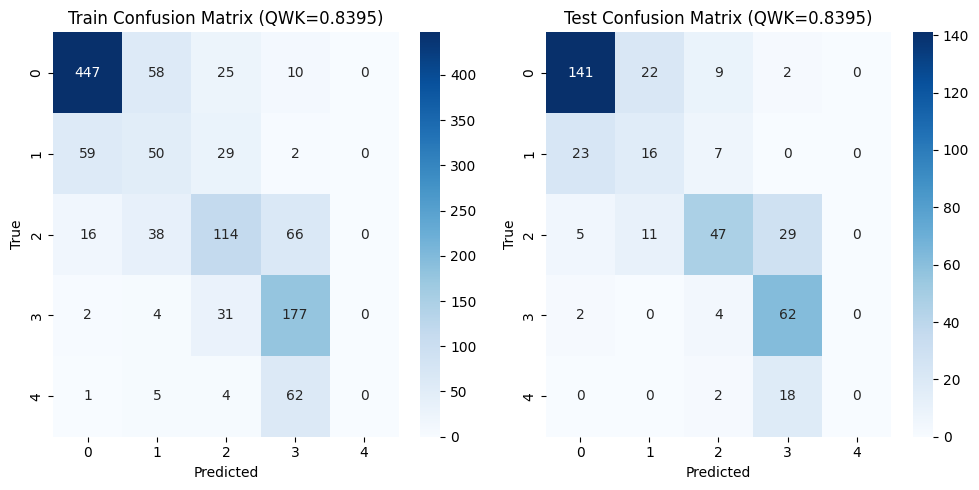

In [3]:
IMG_SIZE=300
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridtrain')
trainset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                augment.TrivialAugmentWide(),
                                                transforms.ToTensor(),
                                                ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)

image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridvalid')
testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
model=optimizermodel.ModelRanger21(filename='DSODHBPASM_ranger21_300circlecroptrivialaug',lr=0.001,num_batches_per_epoch=len(trainloader))

df=model.traintest(150,trainloader,testloader)
custom_utils.plot_metrics(df)
custom_utils.plot_confusion_matrix_with_max_qwk(df)
torch.cuda.empty_cache()

# augmix

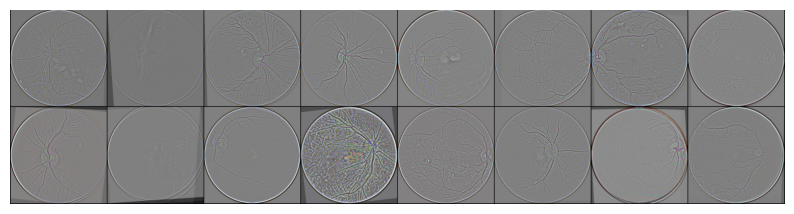

Model : HBPASM with DSOD
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 8100 of 11250
warm down will decay until 3e-05 lr
----------------------------------------Epoch: 1----------------------------------------
params size saved
total param groups = 1
total params in groups = 558
 [=======================================>]  Step: 533ms | Tot: 40s73ms | loss: 2.0208 | tra 75/75  

Train set: Average loss: 2.0229, Cohen's Kappa: 0.0343, QWK Score: 0.0483, Accuracy: (37.17%), 

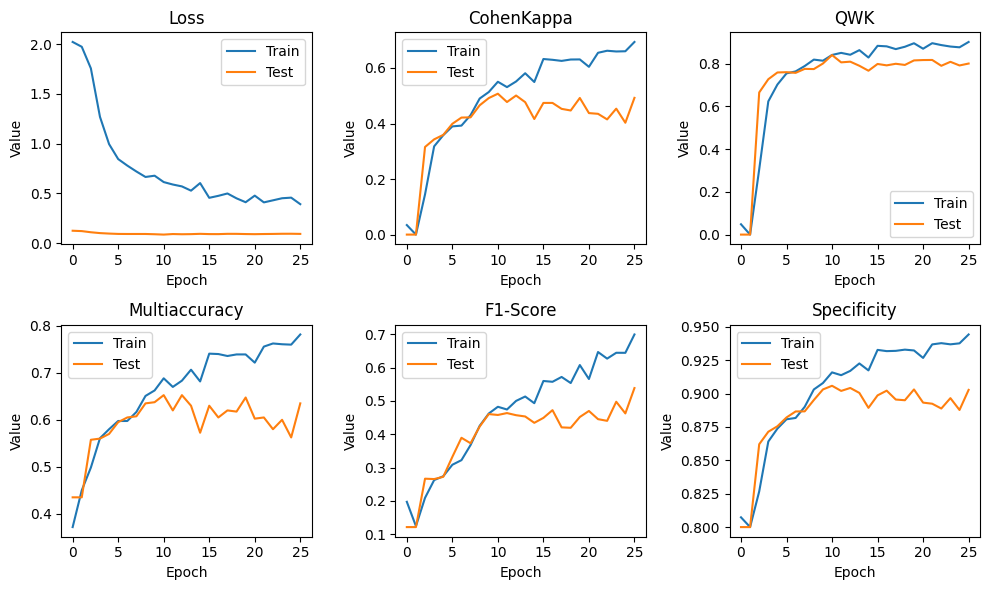

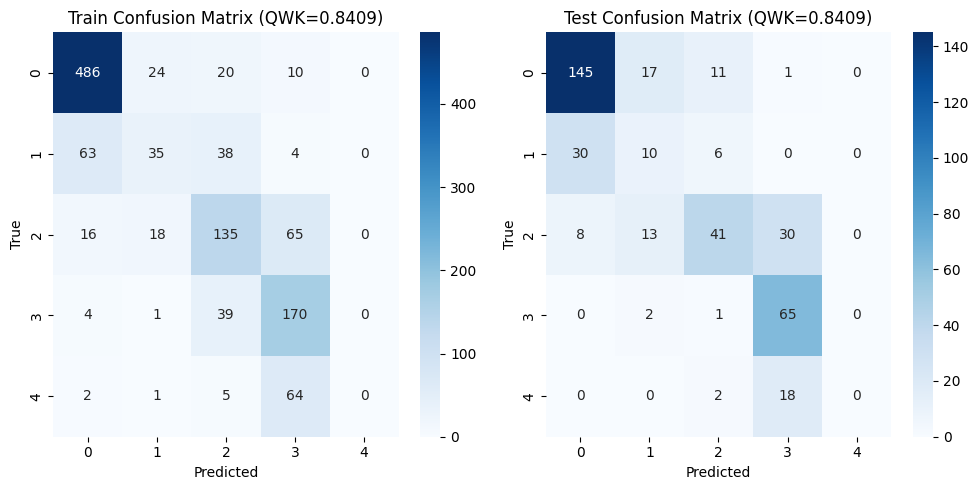

In [4]:
IMG_SIZE=300
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridtrain')
trainset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                augment.AugMix(),
                                                transforms.ToTensor(),
                                                ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)

image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridvalid')
testset = datasets.ImageFolder(image_dir, transform=transforms.Compose([
                                                transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
                                                transforms.ToTensor(),
                                                ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)
cudnn.benchmark = True
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
model=optimizermodel.ModelRanger21(filename='DSODHBPASM_ranger21_300circlecropaugmix',lr=0.001,num_batches_per_epoch=len(trainloader))

df=model.traintest(150,trainloader,testloader)
custom_utils.plot_metrics(df)
custom_utils.plot_confusion_matrix_with_max_qwk(df)
torch.cuda.empty_cache()

# gridmask

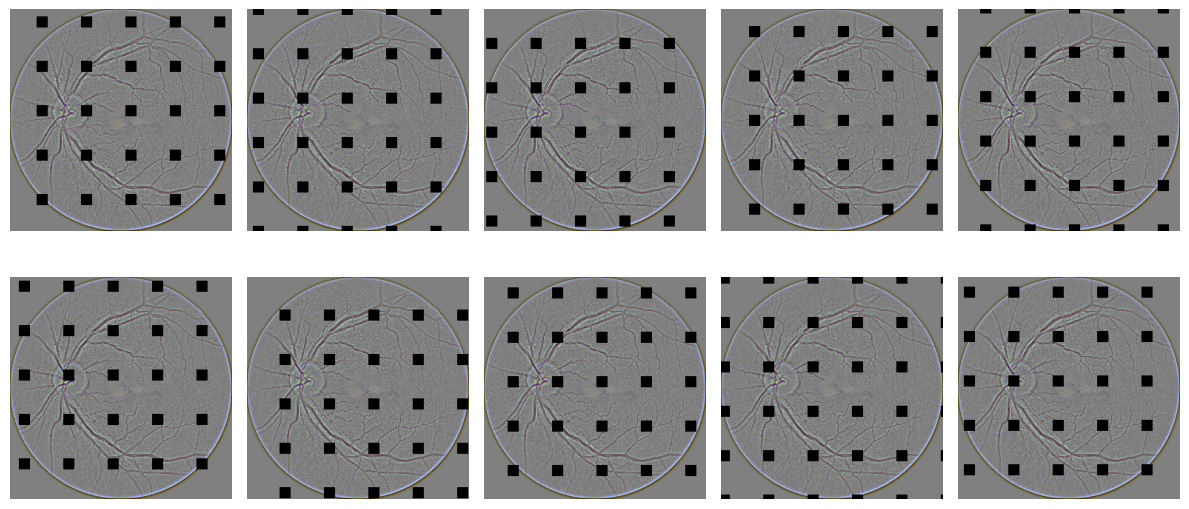

Model : HBPASM with DSOD
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 8100 of 11250
warm down will decay until 3e-05 lr
----------------------------------------Epoch: 1----------------------------------------
params size saved
total param groups = 1
total params in groups = 558
 [=======================================>]  Step: 1s310ms | Tot: 1m39s | loss: 1.9934 | tra 75/75 5  

Train set: Average loss: 2.0231, Cohen's Kappa: -0.0033, QWK Score: 0.0117, Accuracy: (32.83%

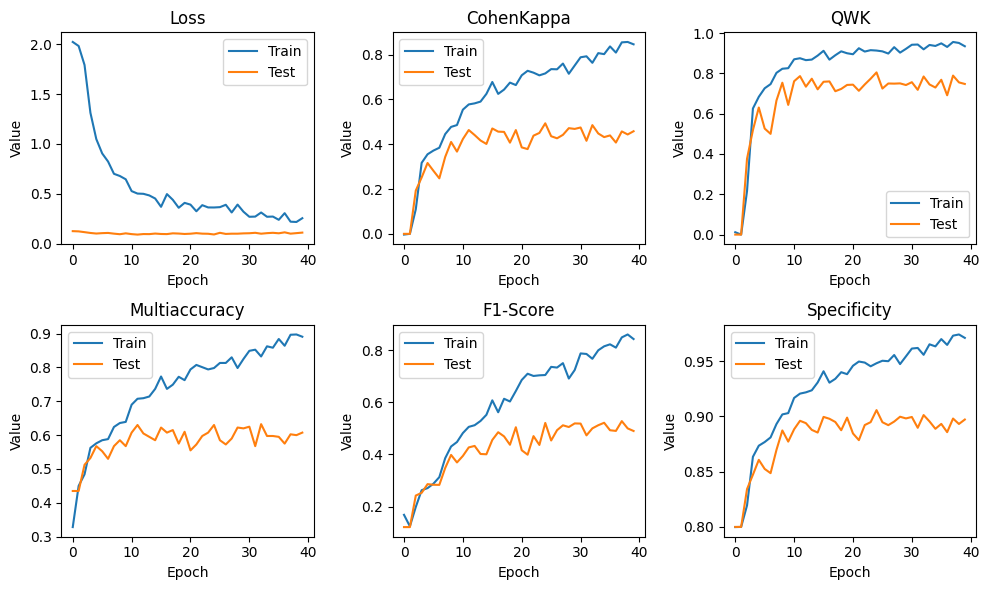

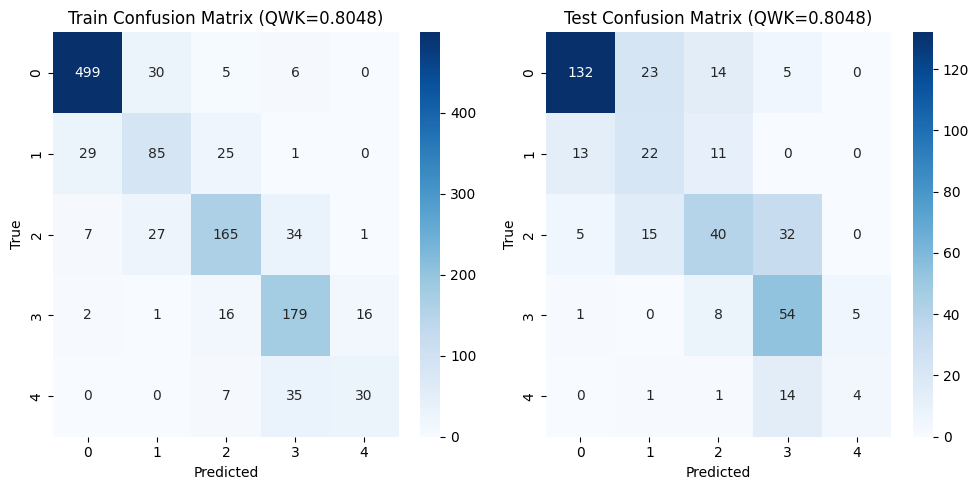

In [5]:
class GridMask(DualTransform):

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5,gridsize=4):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.gridsize=4
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                            #/ 1.3 when fill mode =2 
                             int(i * grid_h) : int(i * grid_h + grid_h / self.gridsize),
                             int(j * grid_w) : int(j * grid_w + grid_w / self.gridsize)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        
        #mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        pil_image = Image.fromarray(mask)
        pil_image = pil_image.rotate(0)
        mask = np.array(pil_image)
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')
IMG_SIZE=300
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridtrain')
trainset = CustomImageFolder(image_dir, transform=A.Compose([
                                                    A.Resize(IMG_SIZE, IMG_SIZE), 
                                                    GridMask(num_grid=5, mode=0,rotate=10,always_apply=True,gridsize=4),
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225],
                                                    ),
                                                    ToTensorV2()
                                                ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridvalid')
testset = CustomImageFolder(image_dir, transform=A.Compose([
                                                    A.Resize(IMG_SIZE, IMG_SIZE), 
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225],
                                                    ),
                                                    ToTensorV2()
                                                ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)
cudnn.benchmark = True

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
visualize_augmentations(trainset)
model=optimizermodel.ModelRanger21(filename='DSODHBPASM_ranger21_300circlecropgridmask',lr=0.001,num_batches_per_epoch=len(trainloader))

df=model.traintest(150,trainloader,testloader)
custom_utils.plot_metrics(df)
custom_utils.plot_confusion_matrix_with_max_qwk(df)
torch.cuda.empty_cache()

# fencemask

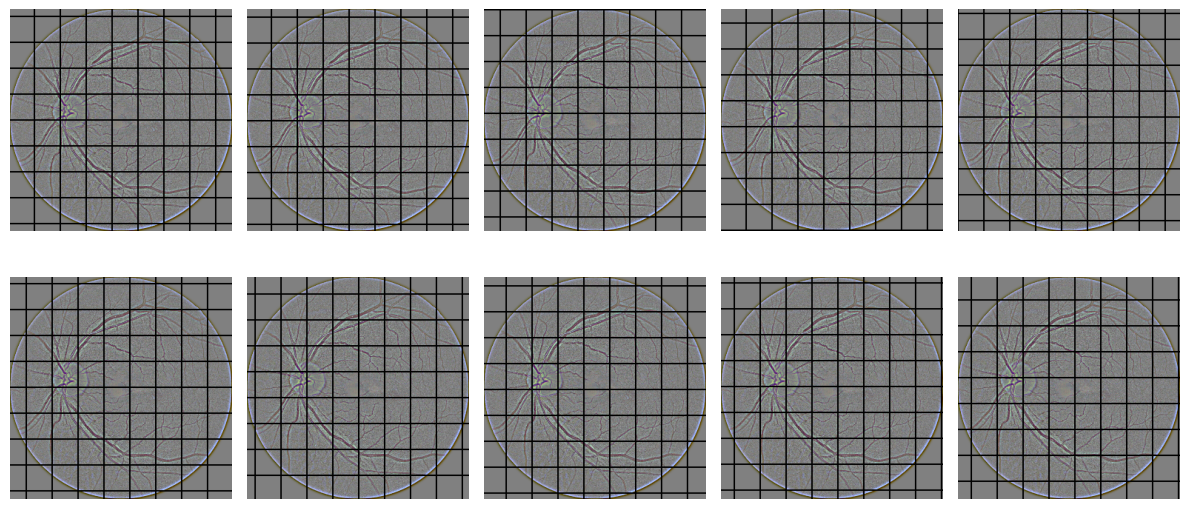

Model : HBPASM with DSOD


e:\FYP\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 150 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 8100 of 11250
warm down will decay until 3e-05 lr
----------------------------------------Epoch: 1----------------------------------------
params size saved
total param groups = 1
total params in groups = 558
 [=======================================>]  Step: 1s370ms | Tot: 1m42s | loss: 2.0026 | tra 75/75 5  

Train set: Average loss: 2.0215, Cohen's Kappa: 0.0074, QWK Score: 0.0106, Accuracy: (37.83%), F1-Score: 0.1707, Speci

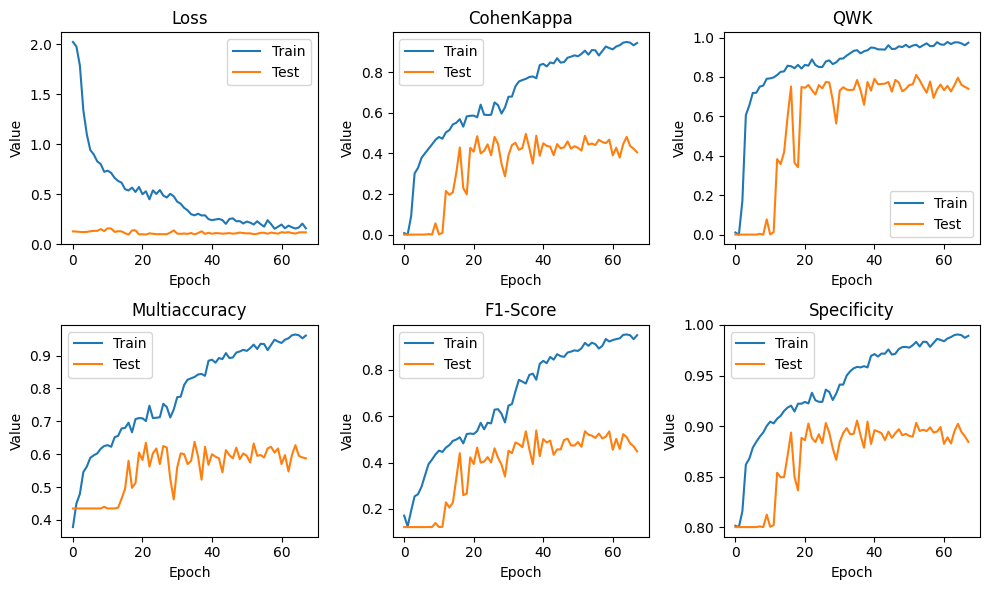

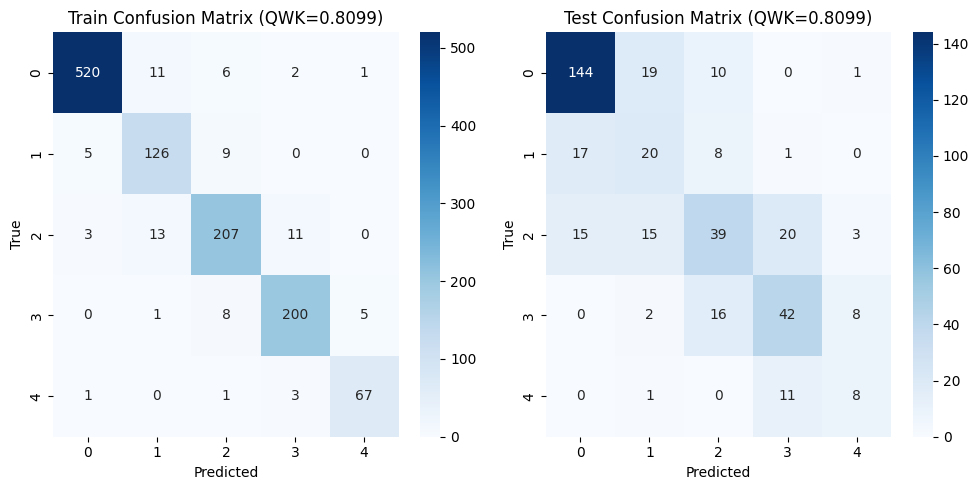

In [5]:
class FenceMask(DualTransform):

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5,gridsize=4):
        super(FenceMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.gridsize=4
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g+15
                grid_w = width / n_g+15
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                            #/ 1.3 when fill mode =2 
                             int(i * grid_h) : int(i * grid_h + grid_h / self.gridsize+25),
                             int(j * grid_w) : int(j * grid_w + grid_w / self.gridsize+25)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        
        #mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        pil_image = Image.fromarray(mask)
        pil_image = pil_image.rotate(0)
        mask = np.array(pil_image)
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')
    
IMG_SIZE=300
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridtrain')
trainset = CustomImageFolder(image_dir, transform=A.Compose([
                                                    A.Resize(IMG_SIZE, IMG_SIZE), 
                                                    FenceMask(num_grid=15, mode=1,rotate=10,always_apply=True,gridsize=1.25),
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225],
                                                    ),
                                                    ToTensorV2()
                                                ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)
image_dir = os.path.join('..', 'dataset','ben processed circle crop','deepdridvalid')
testset = CustomImageFolder(image_dir, transform=A.Compose([
                                                    A.Resize(IMG_SIZE, IMG_SIZE), 
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225],
                                                    ),
                                                    ToTensorV2()
                                                ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
visualize_augmentations(trainset)
cudnn.benchmark = True
model=optimizermodel.ModelRanger21(filename='DSODHBPASM_ranger21_300circlecropfencemask',lr=0.001,num_batches_per_epoch=len(trainloader))

df=model.traintest(150,trainloader,testloader)
custom_utils.plot_metrics(df)
custom_utils.plot_confusion_matrix_with_max_qwk(df)
torch.cuda.empty_cache()
